# Capstone Project - Battle of Neighborhoods: Restaurants in Mumbai

## 1. Importing Libraries and Preparing Data

In [1]:
import pandas as pd # library for data analsysis
from bs4 import BeautifulSoup
import requests # library to handle requests
import numpy as np # library to handle data in a vectorized manner
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas import json_normalize # tranform JSON file into a pandas dataframe
import folium # map rendering library
from sklearn.cluster import KMeans # import k-means from clustering stage
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
df_list = pd.read_html(url)
mumbai_data = df_list[0]
mumbai_data.rename(columns = {'Area':'Neighborhood', 'Location':'Borough'}, inplace = True)

In [3]:
mumbai_data.head()

,Neighborhood,Borough,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,Chakala,"Andheri,Western Suburbs",19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270


In [4]:
mumbai_data.shape

(93, 4)

In [5]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(mumbai_data['Borough'].unique()),
        mumbai_data.shape[0]
    )
)

The dataframe has 31 boroughs and 93 neighborhoods.


## 2. Explore and cluster the neighborhoods in Mumbai

### 2.1 Get the latitude and longitude values of Mumbai

In [6]:
address = 'Mumbai, M'

geolocator = Nominatim(user_agent="mumbai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai are 19.12195775, 72.90929420210506.


### 2.2 Create a map of Mumbai with neighborhoods superimposed on top

In [95]:
# create map of Mumbai using latitude and longitude values
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)
map_mumbai

In [96]:
# create a Stamen Toner map
mumbai_map_1 = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='Stamen Toner')

# display map
mumbai_map_1

In [97]:
# add markers to map
for lat, lng, borough, neighborhood in zip(mumbai_data['Latitude'], mumbai_data['Longitude'], mumbai_data['Borough'], mumbai_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  
    
map_mumbai

### 2.3 Defining Foursquare Credentials and Version

In [9]:
CLIENT_ID = 'JB40EQRMBFDYTMSU4K0A0BMJYNSSSUI5LMMZV5J2JR3GWMVY'
CLIENT_SECRET = 'I3XR3D5RL0IXRGG0UMTWACTZU2POYDHCBE0HEUVPMHY4KTMQ'
VERSION = '20180605'
LIMIT = 100

### 2.4 Explore the first neighborhood in our data frame

In [10]:
# The first neighborhood in our dataframe
mumbai_data.loc[0, 'Neighborhood']

'Amboli'

#### Now, let's get the top 100 venues that are in Amboli within a radius of 500 meters.

In [11]:
neighborhood_latitude = mumbai_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = mumbai_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = mumbai_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Amboli are 19.1293, 72.8434.


In [12]:
radius=500
search_query = 'Restaurant'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Subway,Sandwich Place,19.127860,72.844461
1,Cafe Arfa,Indian Restaurant,19.128930,72.847140
2,"5 Spice , Bandra",Chinese Restaurant,19.130421,72.847206
3,Cafe Coffee Day,Coffee Shop,19.127748,72.844663
4,Apple Service Centre,IT Services,19.128036,72.842718


In [15]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

9 venues were returned by Foursquare.


In [16]:
print ('{} unique categories in Mumbai'.format(nearby_venues['categories'].value_counts().shape[0]))

9 unique categories in Mumbai


In [17]:
print (nearby_venues['categories'].value_counts()[0:10])

IT Services             1
Asian Restaurant        1
Coffee Shop             1
Gym                     1
Chinese Restaurant      1
Fast Food Restaurant    1
Indian Restaurant       1
Playground              1
Sandwich Place          1
Name: categories, dtype: int64


### 2.5 Explore Neighbourhoods in Mumbai

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
mumbai_venues = getNearbyVenues(names=mumbai_data['Neighborhood'],
                                   latitudes=mumbai_data['Latitude'],
                                   longitudes=mumbai_data['Longitude']
                                  )

Amboli
Chakala
D.N. Nagar
Four Bungalows
Lokhandwala
Marol
Sahar
Seven Bungalows
Versova
Mira Road
Bhayandar
Uttan
Bandstand Promenade
Kherwadi
Pali Hill
I.C. Colony
Gorai
Dahisar
Aarey Milk Colony
Bangur Nagar
Jogeshwari West
Juhu
Charkop
Poisar
Mahavir Nagar
Thakur village
Pali Naka
Khar Danda
Dindoshi
Sunder Nagar
Kalina
Naigaon
Nalasopara
Virar
Irla
Vile Parle
Bhandup
Amrut Nagar
Asalfa
Pant Nagar
Kanjurmarg
Nehru Nagar
Nahur
Chandivali
Hiranandani Gardens
Indian Institute of Technology Bombay campus
Vidyavihar
Vikhroli
Chembur
Deonar
Mankhurd
Mahul
Agripada
Altamount Road
Bhuleshwar
Breach Candy
Carmichael Road
Cavel
Churchgate
Cotton Green
Cuffe Parade
Cumbala Hill
Currey Road
Dhobitalao
Dongri
Kala Ghoda
Kemps Corner
Lower Parel
Mahalaxmi
Mahim
Malabar Hill
Marine Drive
Marine Lines
Mumbai Central
Nariman Point
Prabhadevi
Sion
Walkeshwar
Worli
C.G.S. colony
Dagdi Chawl
Navy Nagar
Hindu colony
Ballard Estate
Chira Bazaar
Fanas Wadi
Chor Bazaar
Matunga
Parel
Gowalia Tank
Dava Baza

#### Let's check the size of the resulting dataframe

In [20]:
print(mumbai_venues.shape)
mumbai_venues.head()

(1348, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,19.1293,72.8434,Subway,19.127860,72.844461,Sandwich Place
1,Amboli,19.1293,72.8434,Cafe Arfa,19.128930,72.847140,Indian Restaurant
2,Amboli,19.1293,72.8434,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
3,Amboli,19.1293,72.8434,Cafe Coffee Day,19.127748,72.844663,Coffee Shop
4,Amboli,19.1293,72.8434,Apple Service Centre,19.128036,72.842718,IT Services


#### Create a Data-Frame out of it to concentrate only on Restaurants 

In [21]:
mumbai_restaurants = mumbai_venues[mumbai_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
mumbai_restaurants.index = np.arange(1, len(mumbai_restaurants )+1)

In [22]:
mumbai_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Amboli,19.129300,72.843400,Cafe Arfa,19.128930,72.847140,Indian Restaurant
2,Amboli,19.129300,72.843400,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
3,Amboli,19.129300,72.843400,Spices & Chillies,19.127765,72.844131,Asian Restaurant
4,Amboli,19.129300,72.843400,Nukkad Food Bistro,19.126058,72.846618,Fast Food Restaurant
5,Chakala,19.111388,72.860833,Faaso's,19.113938,72.862330,Fast Food Restaurant


In [23]:
mumbai_restaurants.shape

(423, 7)

In [24]:
print(mumbai_restaurants['Venue Category'].value_counts())

Indian Restaurant                 166
Fast Food Restaurant               53
Chinese Restaurant                 40
Restaurant                         34
Italian Restaurant                 23
Seafood Restaurant                 21
Vegetarian / Vegan Restaurant      19
Asian Restaurant                   13
Japanese Restaurant                 8
Mediterranean Restaurant            6
American Restaurant                 5
French Restaurant                   5
Mexican Restaurant                  3
Middle Eastern Restaurant           3
Dim Sum Restaurant                  3
Cantonese Restaurant                2
North Indian Restaurant             2
Falafel Restaurant                  2
Bengali Restaurant                  2
Mughlai Restaurant                  1
Udupi Restaurant                    1
Maharashtrian Restaurant            1
Goan Restaurant                     1
New American Restaurant             1
Parsi Restaurant                    1
Dumpling Restaurant                 1
Tex-Mex Rest

In [25]:
print('There are {} uniques categories.'.format(len(mumbai_restaurants['Venue Category'].unique())))

There are 32 uniques categories.


In [26]:
# create a dataframe of top 10 categories
mumbai_venues_top10 = mumbai_restaurants['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
mumbai_venues_top10=mumbai_venues_top10.reset_index()

mumbai_venues_top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
mumbai_venues_top10

,Venue_Category,Frequency
0,Indian Restaurant,166
1,Fast Food Restaurant,53
2,Chinese Restaurant,40
3,Restaurant,34
4,Italian Restaurant,23
5,Seafood Restaurant,21
6,Vegetarian / Vegan Restaurant,19
7,Asian Restaurant,13
8,Japanese Restaurant,8
9,Mediterranean Restaurant,6


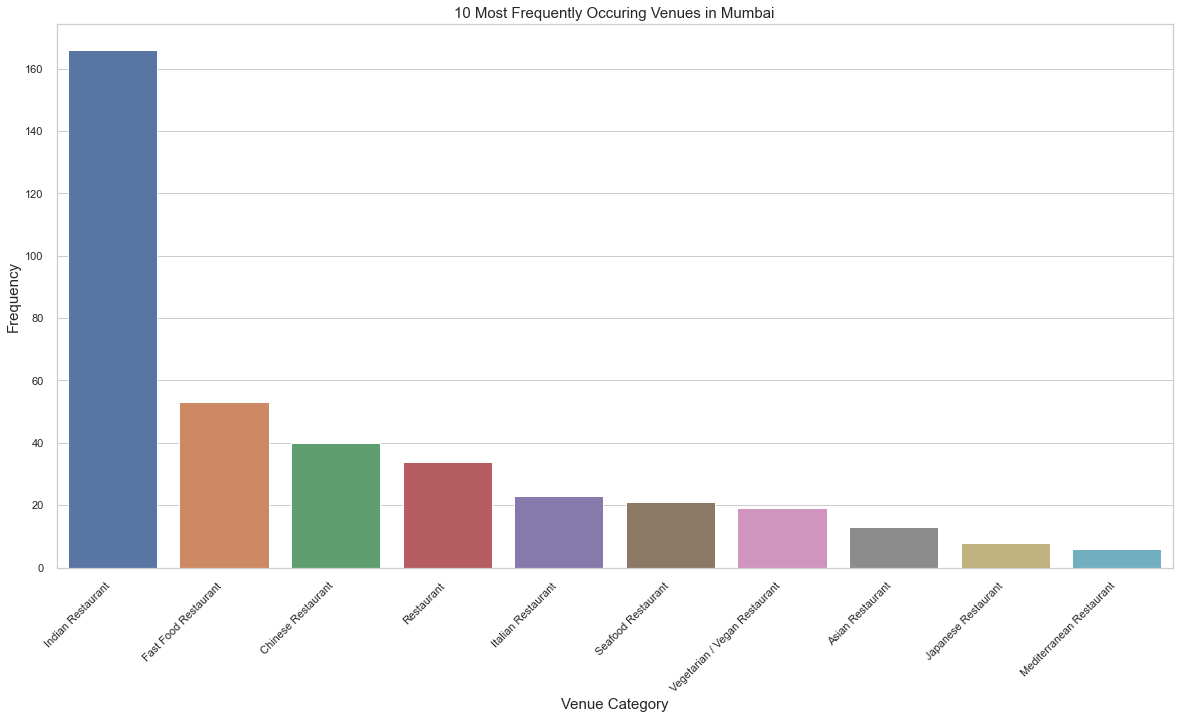

<Figure size 1440x720 with 0 Axes>

In [86]:
s=sns.barplot(x="Venue_Category", y="Frequency", data=mumbai_venues_top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Venues in Mumbai', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(20,10))
plt.show()

In [28]:
mumbai_restaurant = mumbai_restaurants.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())

In [29]:
mumbai_restaurant

Neighborhood
Agripada                2
Altamount Road          1
Amboli                  4
Amrut Nagar            16
Bandstand Promenade     4
                       ..
Uttan                   1
Vidyavihar              2
Vile Parle             12
Walkeshwar              1
Worli                   5
Name: Venue Category, Length: 73, dtype: int64

## 3. Analyze Each Neighborhood

In [30]:
# one hot encoding
mumbai_onehot = pd.get_dummies(mumbai_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mumbai_onehot['Neighborhood'] = mumbai_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]

mumbai_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Bengali Restaurant,Cantonese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Falafel Restaurant,...,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Parsi Restaurant,Restaurant,Seafood Restaurant,South Indian Restaurant,Tex-Mex Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant
1,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Chakala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### And let's examine the new dataframe size

In [31]:
mumbai_onehot.shape

(423, 33)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [32]:
mumbai_grouped = mumbai_onehot.groupby('Neighborhood').mean().reset_index()
mumbai_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Bengali Restaurant,Cantonese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Falafel Restaurant,...,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Parsi Restaurant,Restaurant,Seafood Restaurant,South Indian Restaurant,Tex-Mex Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant
0,Agripada,0.0000,0.0000,0.0000,0.0,0.000000,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.5000,0.000000,0.0,0.0,0.0,0.000000
1,Altamount Road,0.0000,0.0000,0.0000,0.0,0.000000,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000
2,Amboli,0.0000,0.0000,0.2500,0.0,0.000000,0.2500,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000
3,Amrut Nagar,0.0625,0.0625,0.0625,0.0,0.000000,0.0625,0.0,0.0,0.0625,...,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0,0.000000
4,Bandstand Promenade,0.0000,0.0000,0.0000,0.0,0.000000,0.2500,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Uttan,0.0000,0.0000,0.0000,0.0,0.000000,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000
69,Vidyavihar,0.0000,0.0000,0.0000,0.0,0.000000,0.5000,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000
70,Vile Parle,0.0000,0.0000,0.0000,0.0,0.083333,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.083333,0.0,0.0,0.0,0.083333
71,Walkeshwar,0.0000,0.0000,0.0000,0.0,0.000000,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000


#### Let's confirm the new size

In [33]:
mumbai_grouped.shape

(73, 33)

#### Let's print each neighborhood along with the top 5 most common venues

In [34]:
num_top_venues = 5

for hood in mumbai_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = mumbai_grouped[mumbai_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agripada----
                      venue  freq
0                Restaurant   0.5
1         Indian Restaurant   0.5
2         Afghan Restaurant   0.0
3  Maharashtrian Restaurant   0.0
4          Udupi Restaurant   0.0


----Altamount Road----
                      venue  freq
0         Indian Restaurant   1.0
1         Afghan Restaurant   0.0
2  Maharashtrian Restaurant   0.0
3          Udupi Restaurant   0.0
4        Tex-Mex Restaurant   0.0


----Amboli----
                  venue  freq
0  Fast Food Restaurant  0.25
1      Asian Restaurant  0.25
2    Chinese Restaurant  0.25
3     Indian Restaurant  0.25
4      Parsi Restaurant  0.00


----Amrut Nagar----
                      venue  freq
0         Indian Restaurant  0.38
1      Fast Food Restaurant  0.12
2         Afghan Restaurant  0.06
3        Falafel Restaurant  0.06
4  Mediterranean Restaurant  0.06


----Bandstand Promenade----
                     venue  freq
0     Fast Food Restaurant  0.25
1       Italian Restaurant  0.2

### Let's put that into a pandas dataframe

#### First, let's write a function to sort the venues in descending order.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mumbai_grouped['Neighborhood']

for ind in np.arange(mumbai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mumbai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agripada,Restaurant,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Parsi Restaurant,North Indian Restaurant
1,Altamount Road,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
2,Amboli,Fast Food Restaurant,Asian Restaurant,Chinese Restaurant,Indian Restaurant,Parsi Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant
3,Amrut Nagar,Indian Restaurant,Fast Food Restaurant,Afghan Restaurant,Falafel Restaurant,Mediterranean Restaurant,American Restaurant,Italian Restaurant,Restaurant,Chinese Restaurant,Asian Restaurant
4,Bandstand Promenade,Fast Food Restaurant,Italian Restaurant,Indian Restaurant,Chinese Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,Afghan Restaurant


## 4. Cluster Neighborhoods

### Let's identify the best “K” using a famous analytical approach: the elbow method

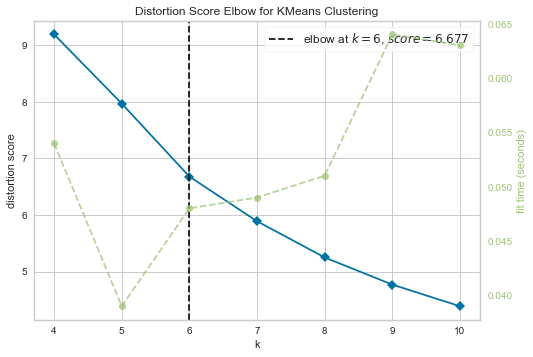

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
mumbai_part_clustering = mumbai_grouped.drop('Neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,11))

visualizer.fit(mumbai_part_clustering)        # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### Run k-means to cluster the neighborhood into 6 clusters.

In [37]:
# set number of clusters
kclusters = 6

mumbai_grouped_clustering = mumbai_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 5, 0, 5, 0, 1, 5, 3, 4])

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mumbai_merged = mumbai_data

# merge mumbai_grouped with mumbai_data to add latitude/longitude for each neighborhood
mumbai_merged = mumbai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

mumbai_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400,5.0,Fast Food Restaurant,Asian Restaurant,Chinese Restaurant,Indian Restaurant,Parsi Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant
1,Chakala,"Andheri,Western Suburbs",19.111388,72.860833,5.0,Restaurant,Fast Food Restaurant,Asian Restaurant,Indian Restaurant,Seafood Restaurant,Falafel Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373,1.0,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210,5.0,Vegetarian / Vegan Restaurant,Restaurant,American Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Parsi Restaurant,North Indian Restaurant,New American Restaurant
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270,0.0,Restaurant,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Parsi Restaurant,North Indian Restaurant


In [47]:
mumbai_merged.shape

(93, 15)

### Finally, let's visualize the resulting clusters

In [45]:
mumbai_merged = mumbai_merged.fillna(0)
mumbai_merged['Cluster Labels'].astype(int)

0     5
1     5
2     1
3     5
4     0
     ..
88    1
89    4
90    0
91    3
92    2
Name: Cluster Labels, Length: 93, dtype: int32

In [98]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_merged['Latitude'], mumbai_merged['Longitude'], mumbai_merged['Neighborhood'], mumbai_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [83]:
clusterdata = pd.merge(mumbai_onehot.groupby('Neighborhood').sum(),mumbai_merged[['Neighborhood','Cluster Labels']],left_on='Neighborhood', right_on='Neighborhood',how='inner')
clusterdata = clusterdata.iloc[:,1:].groupby('Cluster Labels').sum().transpose()
clusterdata.head()

Cluster Labels,0.0,1.0,2.0,3.0,4.0,5.0
Afghan Restaurant,1,0,0,0,0,0
American Restaurant,3,1,0,0,0,1
Asian Restaurant,8,0,0,0,0,5
Bengali Restaurant,1,0,0,0,1,0
Cantonese Restaurant,2,0,0,0,0,0


In [73]:
# function for visualizing clusters
def plot_bar(clusternumber):
    sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
    df = clusterdata[[clusternumber]].drop(clusterdata[[clusternumber]][clusterdata[clusternumber]==0].index)
    chart = sns.barplot(x=df.index, y=clusternumber, data=df)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

## 5. Examine Clusters

### Cluster 1

In [58]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 0, mumbai_merged.columns[[0] + list(range(5, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Lokhandwala,Restaurant,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Parsi Restaurant,North Indian Restaurant
5,Marol,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Restaurant,Asian Restaurant,Tex-Mex Restaurant,Udupi Restaurant,South Indian Restaurant,Seafood Restaurant,Mediterranean Restaurant
6,Sahar,0,0,0,0,0,0,0,0,0,0
7,Seven Bungalows,Indian Restaurant,Chinese Restaurant,Seafood Restaurant,South Indian Restaurant,Dim Sum Restaurant,North Indian Restaurant,Afghan Restaurant,New American Restaurant,Middle Eastern Restaurant,Mughlai Restaurant
8,Versova,0,0,0,0,0,0,0,0,0,0
10,Bhayandar,0,0,0,0,0,0,0,0,0,0
13,Kherwadi,Indian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,German Restaurant,Seafood Restaurant,Fast Food Restaurant,Asian Restaurant,Mediterranean Restaurant,South Indian Restaurant,Tex-Mex Restaurant
17,Dahisar,Restaurant,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Parsi Restaurant,North Indian Restaurant
18,Aarey Milk Colony,0,0,0,0,0,0,0,0,0,0
19,Bangur Nagar,0,0,0,0,0,0,0,0,0,0


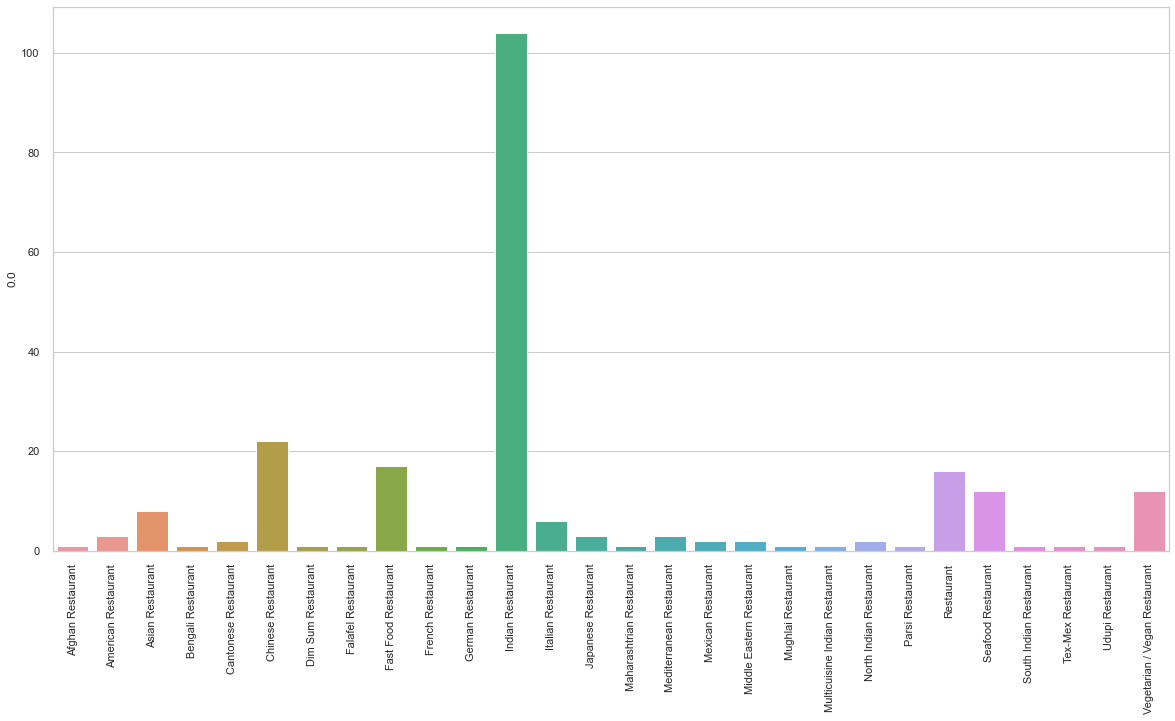

In [74]:
plot_bar(0)

### Cluster 2

In [59]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 1, mumbai_merged.columns[[0] + list(range(5, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,D.N. Nagar,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
11,Uttan,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
45,Indian Institute of Technology Bombay campus,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
49,Deonar,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
53,Altamount Road,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
54,Bhuleshwar,Indian Restaurant,American Restaurant,Fast Food Restaurant,Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,Afghan Restaurant
57,Cavel,Indian Restaurant,Chinese Restaurant,Afghan Restaurant,North Indian Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,Parsi Restaurant
64,Dongri,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
70,Malabar Hill,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
76,Sion,Indian Restaurant,Vegetarian / Vegan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant


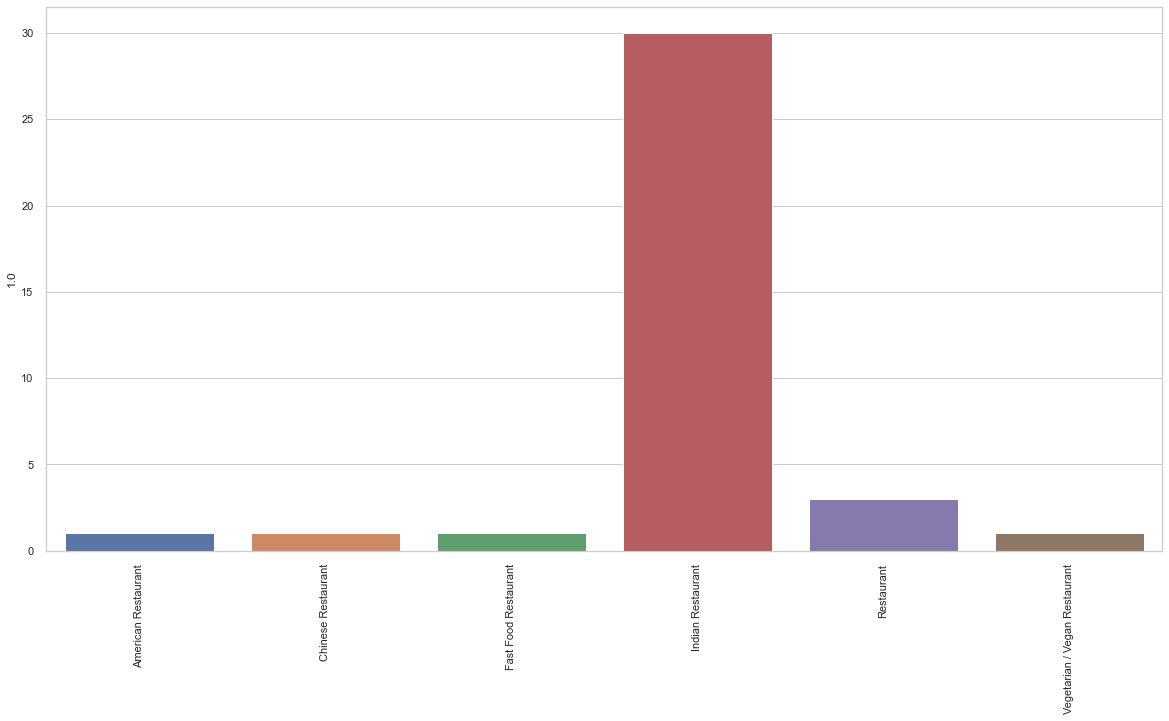

In [75]:
plot_bar(1)

### Cluster 3

In [60]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 2, mumbai_merged.columns[[0] + list(range(5, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Gorai,Seafood Restaurant,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
32,Nalasopara,Seafood Restaurant,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
34,Irla,Seafood Restaurant,Indian Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
78,Worli,Seafood Restaurant,Indian Restaurant,Dumpling Restaurant,Fast Food Restaurant,Afghan Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant
92,Thane,Indian Restaurant,Seafood Restaurant,Fast Food Restaurant,Afghan Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant


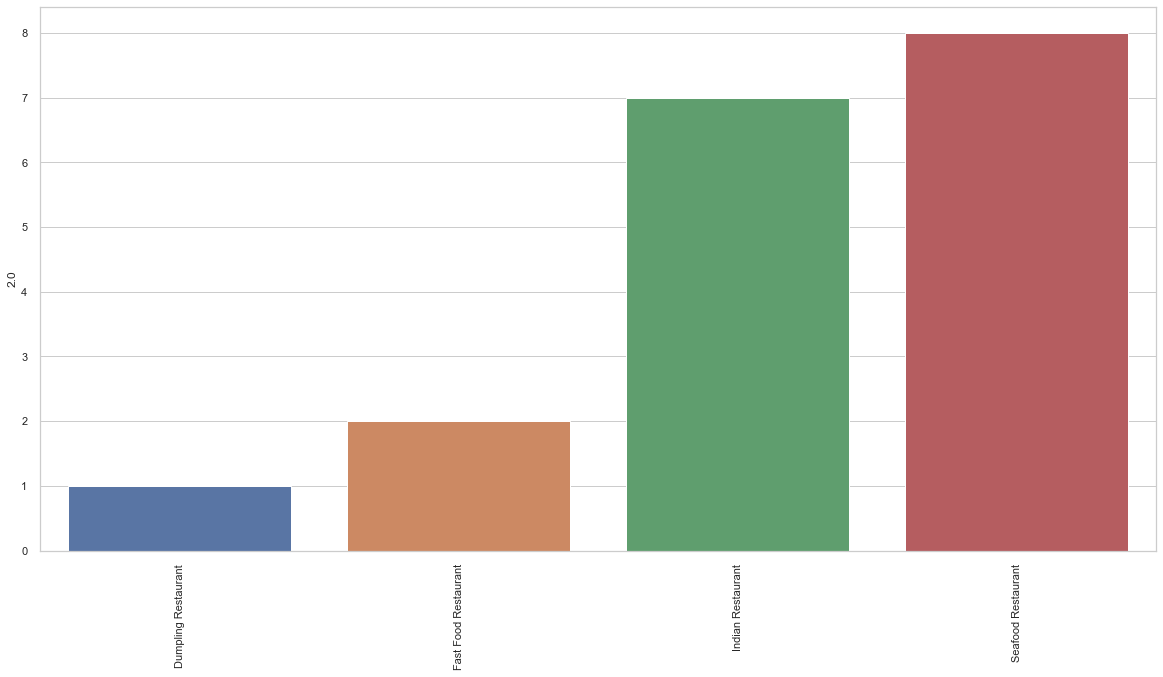

In [76]:
plot_bar(2)

### Cluster 4

In [61]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 3, mumbai_merged.columns[[0] + list(range(5, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,C.G.S. colony,Fast Food Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
91,Dharavi,Fast Food Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant


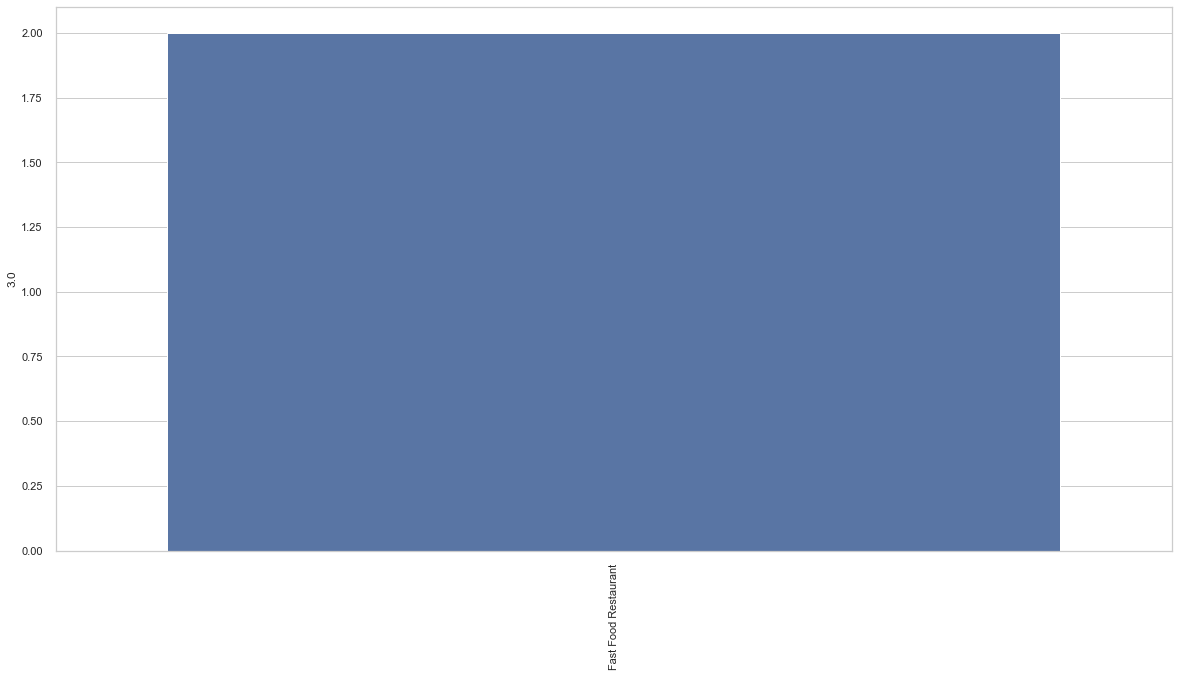

In [77]:
plot_bar(3)

### Cluster 5

In [62]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 4, mumbai_merged.columns[[0] + list(range(5, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Mira Road,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Chinese Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Parsi Restaurant
15,I.C. Colony,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant,Afghan Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Parsi Restaurant
22,Charkop,Chinese Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
41,Nehru Nagar,Vegetarian / Vegan Restaurant,Chinese Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Restaurant,Parsi Restaurant,North Indian Restaurant
46,Vidyavihar,Fast Food Restaurant,Chinese Restaurant,Afghan Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Parsi Restaurant
56,Carmichael Road,Fast Food Restaurant,Chinese Restaurant,Bengali Restaurant,Italian Restaurant,Parsi Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant
73,Mumbai Central,Chinese Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Restaurant,North Indian Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant
89,Gowalia Tank,Chinese Restaurant,Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Parsi Restaurant,North Indian Restaurant


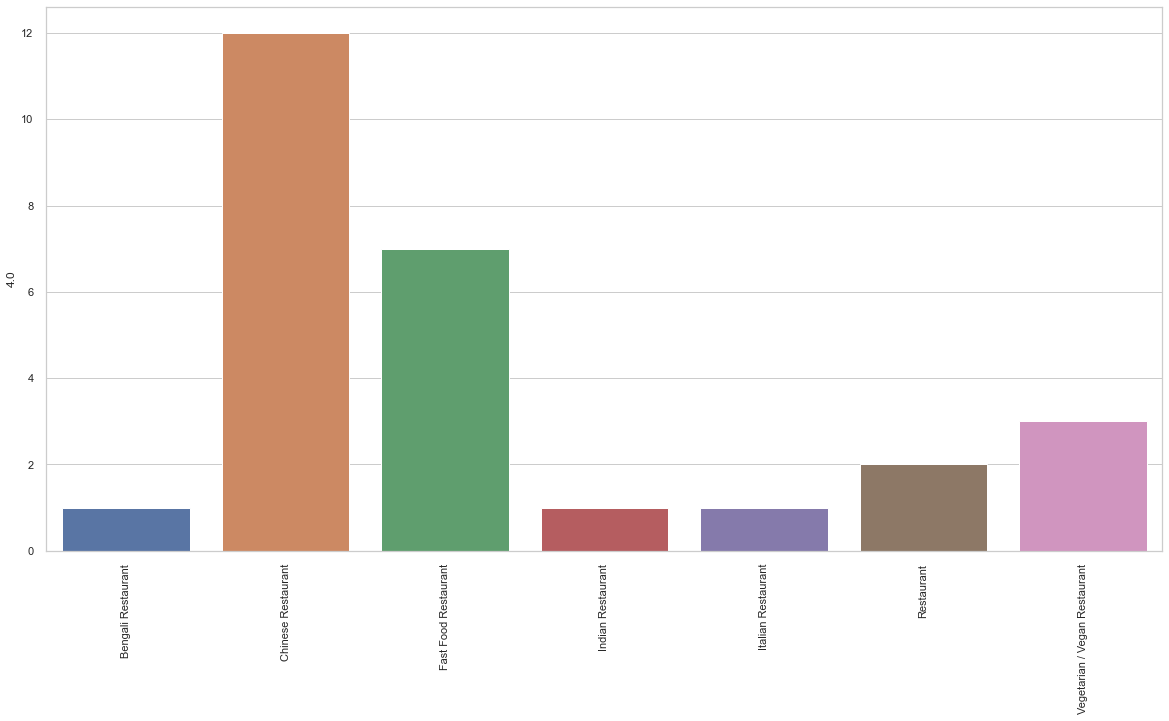

In [78]:
plot_bar(4)

### Cluster 6

In [63]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 5, mumbai_merged.columns[[0] + list(range(5, mumbai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Fast Food Restaurant,Asian Restaurant,Chinese Restaurant,Indian Restaurant,Parsi Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant
1,Chakala,Restaurant,Fast Food Restaurant,Asian Restaurant,Indian Restaurant,Seafood Restaurant,Falafel Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant
3,Four Bungalows,Vegetarian / Vegan Restaurant,Restaurant,American Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Parsi Restaurant,North Indian Restaurant,New American Restaurant
12,Bandstand Promenade,Fast Food Restaurant,Italian Restaurant,Indian Restaurant,Chinese Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,Afghan Restaurant
14,Pali Hill,Fast Food Restaurant,Italian Restaurant,Indian Restaurant,Dim Sum Restaurant,Restaurant,Greek Restaurant,New American Restaurant,Middle Eastern Restaurant,Asian Restaurant,Seafood Restaurant
20,Jogeshwari West,Fast Food Restaurant,Indian Restaurant,Afghan Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Maharashtrian Restaurant
24,Mahavir Nagar,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,Afghan Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Mediterranean Restaurant
28,Dindoshi,Restaurant,Fast Food Restaurant,Afghan Restaurant,Maharashtrian Restaurant,Udupi Restaurant,Tex-Mex Restaurant,South Indian Restaurant,Seafood Restaurant,Parsi Restaurant,North Indian Restaurant
48,Chembur,Fast Food Restaurant,Indian Restaurant,Afghan Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Maharashtrian Restaurant
55,Breach Candy,Japanese Restaurant,Italian Restaurant,Indian Restaurant,French Restaurant,New American Restaurant,Middle Eastern Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,North Indian Restaurant,Mediterranean Restaurant


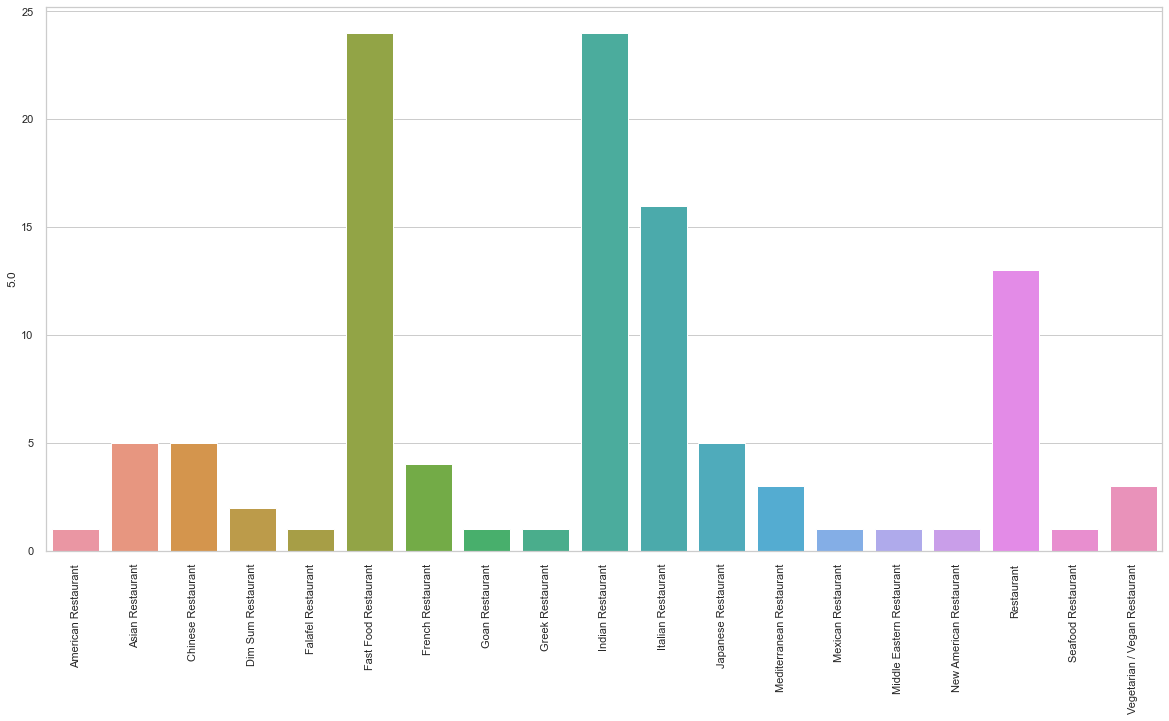

In [79]:
plot_bar(5)